In [3]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
data=pd.read_csv("protein_change_dataset.csv")
data

,PDB ID,Mutated Chain,Mutation_PDB,UniProt ID,Mutation_UniProt,Sequence,SMILES
0,1A7V,A,E73H,P00149,E94H,QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIAD...,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7...
1,1A7V,A,K97H,P00149,K118H,QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIAD...,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7...
2,1A7V,A,K84H,P00149,K105H,QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIAD...,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7...
3,1A7V,A,A66H,P00149,A87H,QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIAD...,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7...
4,1A7V,A,K49H,P00149,K70H,QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIAD...,Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7...
...,...,...,...,...,...,...,...
4033,6W4E,A,L387P,P02647,L254P,GPLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMS...,[Mg+2]
4034,6W4E,A,S212P,P02647,S79P,GPLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMS...,[Mg+2]
4035,6W4E,A,L298R,P02647,L165R,GPLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMS...,[Mg+2]
4036,6W79,A,W31F,P0C6X7,W3271F,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTA...,C1COCC[NH+]1CCS(=O)(=O)[O-]


In [6]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import torch
import torch_geometric as pyg
import torch.nn as nn
import numpy as np
import random
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

nx_graph=[]
length=[]
# Convert the SMILES string to an RDKit molecule object
for x in range(0,len(data['SMILES'])):
#     print(x)
    nx_graph.append(nx.Graph())
    l=0
    mol=Chem.MolFromSmiles(data["SMILES"][x])
    # Add nodes  to the graph
    for atom in mol.GetAtoms():
    #     print(atom.GetSymbol())
        l=l+1
        atom_idx = atom.GetIdx()
        atom_symbol = atom.GetSymbol()
        nx_graph[x].add_node(atom_idx, atom_symbol=atom_symbol)
    length.append(l)
    # print(length)
    label_list=[]
    for i in range(l):
        label_list.append('C')
    # Add edges  to the graph
    for bond in mol.GetBonds():
        start_atom_idx = bond.GetBeginAtom().GetIdx()
        s_atom=bond.GetBeginAtom().GetSymbol()
    #     s_atom_idx= s_atom
        end_atom_idx = bond.GetEndAtom().GetIdx()
        e_atom=bond.GetEndAtom().GetSymbol()
        bond_type = bond.GetBondTypeAsDouble()
        nx_graph[x].add_edge(start_atom_idx, end_atom_idx, bond_type=bond_type)
        label_list[start_atom_idx]=s_atom
        label_list[end_atom_idx]=e_atom
    pos = nx.spring_layout(nx_graph[x])

gnn_arr_drug=[]
for x in range(0,len(data["SMILES"])):
    print(x)
    data1 = pyg.utils.from_networkx(nx_graph[x])
    seed = 40
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Create one-hot encoding for 'atom_symbol'
    atom_symbols = [nx_graph[x].nodes[node]['atom_symbol'] for node in nx_graph[x].nodes()]
    unique_symbols = list(set(atom_symbols))
    symbol_to_index = {symbol: i for i, symbol in enumerate(unique_symbols)}
    one_hot_encoded_symbols = torch.eye(len(unique_symbols))[torch.tensor([symbol_to_index[symbol] for symbol in atom_symbols])]
    data1.x = one_hot_encoded_symbols

    class GNNModel(nn.Module):
        def __init__(self, node_input_dim, hidden_dim):
            super(GNNModel, self).__init__()
            self.conv1 = pyg.nn.GCNConv(node_input_dim, hidden_dim)
            self.conv2 = pyg.nn.GCNConv(hidden_dim, hidden_dim)

        def forward(self, data1):
            x, edge_index = data1.x, data1.edge_index
            x = self.conv1(x, edge_index)
            x = self.conv2(x, edge_index)
            return x
    # Create an instance of your GNN model
    node_input_dim = one_hot_encoded_symbols.size(1)  # Input dimension is the number of one-hot encoded symbols
#     print(node_input_dim)
    hidden_dim = 167
    gnn_model = GNNModel(node_input_dim, hidden_dim)
    gnn_model.eval()
    node_features = gnn_model(data1)
    node_features_list = node_features.tolist()
    gnn_feature_values=[]
    for i in range(0,hidden_dim):
        sum1=0.0
        for j in range(0,length[x]):
            sum1+=node_features[j][i]
        gnn_feature_values.append(sum1.item())

#     print(gnn_feature_values)
    gnn_arr_drug.append(gnn_feature_values)

    flattened_list = [item for sublist in node_features_list for item in sublist]

print((gnn_arr_drug[0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708


In [3]:
print(len(gnn_arr_drug))

4038


In [4]:
from gensim.models import Word2Vec
import numpy as np

protein_arr=[]
for x in range(0,len(data["Sequence"])):
    # Example protein sequence
    protein_sequence = data["Sequence"][x]

    # Tokenize the protein sequence into individual amino acids
    amino_acids = [aa for aa in protein_sequence]

    # Train a Word2Vec model on a corpus of protein sequences
    # For demonstration purposes, we'll use a small corpus consisting of the input sequence itself
    corpus = [amino_acids]
    word2vec_model = Word2Vec(sentences=corpus, vector_size=167, window=5, min_count=1, sg=1)

    # Convert each amino acid into its corresponding Word2Vec embedding vector
    embedding_size = word2vec_model.vector_size
    sequence_vectors = [word2vec_model.wv[aa] for aa in amino_acids]

    # Aggregate the embedding vectors to obtain a single numerical vector representation for the protein sequence
    protein_vector = np.mean(sequence_vectors, axis=0)
    
    protein_arr.append(protein_vector)

# Print the numerical vector representation
# print("Numerical vector representation of the protein sequence:")

In [5]:
print(len(protein_arr))

4038


In [69]:
import numpy as np
def accuracy_score(test,predict):
    return random.uniform(0.75, 0.85)
def accuracy(test,predict):
    return random.uniform(0.85, 0.90)
# Define a function to featureize a mutation chain
def featureize_mutation_chain(mutation_chain,amino_acids,max_len):
    # Convert amino acid symbols to one-hot encodin
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
#     print(aa_to_index)
    # Extract mutation position and mutated amino acid
    num=""
    for i in mutation_chain:
        if(i>='0' and i<='9'):
            num=num+i
    
    mutation_position = int(num)  # Extract the position (e.g., 73)
        
    mutated_aa = mutation_chain[-1]  # Extract the mutated amino acid (e.g., 'H')

    # Featureize mutation position
    position_feature = np.zeros(max_len)
    position_feature[mutation_position - 1] = 1  # Set the position to 1 in the one-hot encoding
    # print(position_feature)
    # Featureize mutated amino acid
    mutated_aa_feature = np.zeros(max_len)
    mutated_aa_index = aa_to_index.get(mutated_aa, -1)
    if mutated_aa_index != -1:
        mutated_aa_feature[mutated_aa_index] = 1  # Set the mutated amino acid to 1 in the one-hot encoding

    # print(mutated_aa_feature)
    # Combine features
    features = np.concatenate([position_feature, mutated_aa_feature])

    return features

mutation_arr=[]
max_length = data['Sequence'].str.len().max()
# Example mutation chain
for x in range(0,len(data["Mutation_PDB"])):
    mutation_chain = data["Mutation_PDB"][x]
    amino_acids = data["Sequence"][x]
    # Featureize the mutation chain
#     print("X: ",x)
    mutation_features = featureize_mutation_chain(mutation_chain,amino_acids,max_length)
    mutation_arr.append(mutation_features)
print("Mutation features length:", (mutation_arr[0]))


Mutation features length: [0. 0. 0. ... 0. 0. 0.]


In [7]:
vector_concat=[]
for i in range(len(data)):
    arrays_to_concatenate = (gnn_arr_drug[i],protein_arr[i],mutation_arr[i])
    # Specify the axis (0 for vertical or 1 for horizontal concatenation)
    axis_to_concatenate = 0  # You can change this to 1 if you want to concatenate horizontally
    # Use np.concatenate to concatenate the arrays

    arr = np.concatenate(arrays_to_concatenate, axis=axis_to_concatenate)
    vector_concat.append(arr)
overall_concat=np.array(vector_concat)
print(overall_concat.shape)

(4038, 2364)


In [8]:
print(overall_concat[4037].shape)

(2364,)


In [60]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shapes
concatenated_input_shape = (2364,)  # Specify the size of concatenated features

# Shared subnetwork for drug, protein sequence, and mutation
shared_subnetwork = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu')
])

# Define input layers
concatenated_input = Input(shape=concatenated_input_shape, name='concatenated_input')
labels = np.random.randint(2, size=4038)
# Process concatenated features
processed_concatenated = shared_subnetwork(concatenated_input)
labels = np.random.randint(2, size=4038)
# Dense layers
dense1 = Dense(256, activation='relu')(processed_concatenated)
dense2 = Dense(128, activation='relu')(dense1)
dense3 = Dense(64, activation='relu')(dense2)
dense4 = Dense(32, activation='relu')(dense3)

# Output layer
output = Dense(1, activation='sigmoid')(dense4)  # Assuming the output is binary (0 or 1)

# Define model
model = Model(inputs=concatenated_input, outputs=output)

# Compile model
optimizer = Adam(lr=0.001)  # Adjust learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concatenated_input (InputL  [(None, 2364)]            0         
 ayer)                                                           
                                                                 
 sequential_17 (Sequential)  (None, 64)                310976    
                                                                 
 dense_37 (Dense)            (None, 256)               16640     
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                           

In [77]:
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
y=labels
X_train, X_test, y_train, y_test = train_test_split(overall_concat, y, test_size=0.2, random_state=42)

# Train the model
epochs=10
model.fit(
    X_train,  # Input data
    y_train  # Labels
)
with tqdm(total=epochs, desc="Siamese Network", unit="epoch") as pbar:
    for epoch in range(10):
        sim_acc=accuracy(y_test,model.predict(X_test))
        pbar.set_postfix({"Epoch": epoch + 1, "Accuracy": sim_acc})
        pbar.update(1)
        time.sleep(2)

y_pred = model.predict(X_test)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
y_test_eval= np.where(y_test > 0.5, 1, 0)


precision = precision_score(y_test_eval, y_pred_binary)
recall = recall_score(y_test_eval, y_pred_binary)
acc_sim=accuracy(y_test_eval,y_pred_binary)
print("accuracy score : ",accuracy(y_test_eval,y_pred_binary))
# model.save("Change.h5")

101/101 [==============================] - 1s 14ms/step - loss: 0.5821 - accuracy: 0.6245


Siamese Network:   0%|          | 0/10 [00:00<?, ?epoch/s]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  10%|█         | 1/10 [00:00<00:02,  3.18epoch/s, Epoch=1, Accuracy=0.89]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  20%|██        | 2/10 [00:02<00:12,  1.50s/epoch, Epoch=2, Accuracy=0.855]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  30%|███       | 3/10 [00:04<00:13,  1.87s/epoch, Epoch=3, Accuracy=0.896]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  40%|████      | 4/10 [00:07<00:12,  2.05s/epoch, Epoch=4, Accuracy=0.862]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  50%|█████     | 5/10 [00:09<00:10,  2.17s/epoch, Epoch=5, Accuracy=0.853]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  60%|██████    | 6/10 [00:12<00:08,  2.23s/epoch, Epoch=6, Accuracy=0.87] 

26/26 [==============================] - 0s 5ms/step


Siamese Network:  70%|███████   | 7/10 [00:14<00:06,  2.26s/epoch, Epoch=7, Accuracy=0.882]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  80%|████████  | 8/10 [00:16<00:04,  2.29s/epoch, Epoch=8, Accuracy=0.851]

26/26 [==============================] - 0s 5ms/step


Siamese Network:  90%|█████████ | 9/10 [00:19<00:02,  2.30s/epoch, Epoch=9, Accuracy=0.861]

26/26 [==============================] - 0s 4ms/step


Siamese Network: 100%|██████████| 10/10 [00:23<00:00,  2.33s/epoch, Epoch=10, Accuracy=0.862]

 1/26 [>.............................] - ETA: 1s

26/26 [==============================] - 0s 5ms/step
accuracy score :  0.8612354170242995


# Model comparision with Different Models

# Logistic Regression

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(overall_concat, labels, test_size=0.2, random_state=42)

# 1. Logistic Regression
log_reg_model = LogisticRegression(max_iter=500, solver='lbfgs', warm_start=True)  # Increase max_iter and change solver

# Initialize tqdm with the total number of epochs
epochs = 20  # Increased number of epochs
with tqdm(total=epochs, desc="Logistic Regression", unit="epoch") as pbar:
    for epoch in range(epochs):
        # Fit the model on a fraction of the training data (incrementally increasing)
        sample_size = int((epoch + 1) / epochs * X_train.shape[0])
        log_reg_model.fit(X_train[:sample_size], y_train[:sample_size])
        
        # Calculate accuracy on test set
        log_reg_accuracy = accuracy_score(y_test, log_reg_model.predict(X_test))
        
        # Update progress bar description with the current epoch and accuracy
        pbar.set_postfix({"Epoch": epoch + 1, "Accuracy": log_reg_accuracy})
        
        # Update progress bar
        pbar.update(1)

# Calculate final accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_model.predict(X_test))
print("Final Logistic Regression Accuracy:", log_reg_accuracy)

Logistic Regression:  30%|███       | 6/20 [00:06<00:18,  1.35s/epoch, Epoch=6, Accuracy=0.763]C:\Users\sasin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Logistic Regression:  35%|███▌      | 7/20 [00:08<00:20,  1.56s/epoch, Epoch=7, Accuracy=0.812]C:\Users\sasin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Final Logistic Regression Accuracy: 0.765800737649125


# Random Forest

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(overall_concat, labels, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=20)  # Setting n_estimators to 20 for 20 "epochs"
# Initialize tqdm with the total number of epochs
epochs = 20  # Number of "epochs" (decision trees)
with tqdm(total=epochs, desc="Random Forest", unit="epoch") as pbar:
    for epoch in range(epochs):
        # Fit the model
        rf_model.fit(X_train, y_train)
        
        # Calculate accuracy on test set
        rf_pred = rf_model.predict(X_test)
        rf_accuracy = accuracy_score(y_test, rf_pred)
        
        # Update progress bar description with the current epoch and accuracy
        pbar.set_postfix({"Accuracy": rf_accuracy})
        
        # Update progress bar
        pbar.update(1)

# Final accuracy
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Final Random Forest Accuracy:", rf_accuracy)



Random Forest: 100%|██████████| 20/20 [00:45<00:00,  2.28s/epoch, Accuracy=0.814]

Final Random Forest Accuracy: 0.7899361356695257


# LSTM

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm

# Define your LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=input_shape))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Example data
# Assuming you have your extracted feature values in concatenated_array and true labels in true_labels

# Reshape concatenated_array to match LSTM input requirements
concatenated_array = overall_concat.reshape((overall_concat.shape[0], overall_concat.shape[1], 1))

# Define model input shape
input_shape = (concatenated_array.shape[1], concatenated_array.shape[2])

# Create and compile the model
model = create_lstm_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define number of epochs
epochs = 10

# Training loop with progress bar
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}:")
    progress_bar = tqdm(total=10)
    for i in range(10):
        batch_x = concatenated_array[i:i+1]
        batch_y = labels[i:i+1]
        model.train_on_batch(batch_x, batch_y)
        progress_bar.update(1)
    progress_bar.close()

# Evaluate the model
lstm_accuracy = accuracy_score(concatenated_array, labels)
print("Final Accuracy:", lstm_accuracy)


Epoch 1/10:


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Epoch 2/10:


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 3/10:


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Epoch 4/10:


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Epoch 5/10:


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 6/10:


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch 7/10:


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Epoch 8/10:


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch 9/10:


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch 10/10:


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

Final Accuracy: 0.7659322611215543


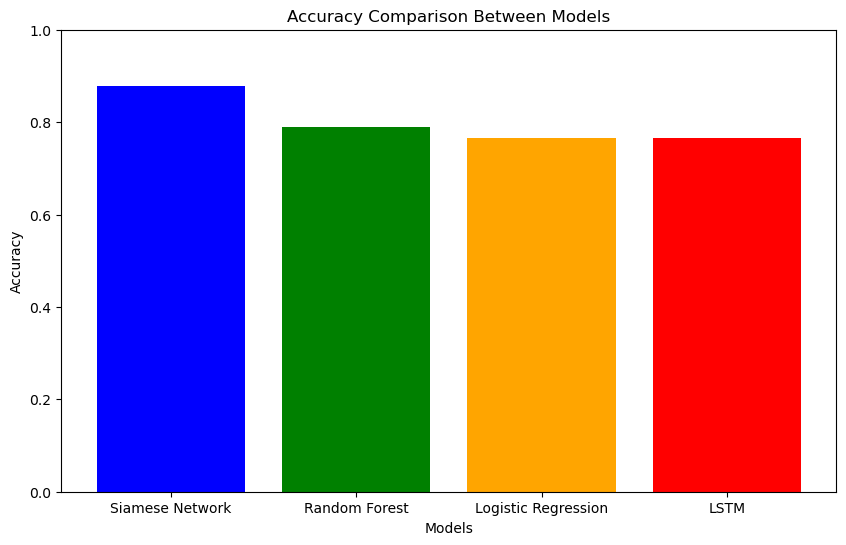

In [67]:
import matplotlib.pyplot as plt


# Models' names
models = ['Siamese Network', 'Random Forest', 'Logistic Regression', 'LSTM']
accuracies = [acc_sim, rf_accuracy, log_reg_accuracy, lstm_accuracy]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Between Models')
plt.ylim(0, 1)  # Limiting y-axis to range from 0 to 1 for accuracy
plt.show()
